# Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, KFold, GridSearchCV
from collections import Counter
import time
from tqdm.notebook import tqdm
!pip install bayesian-optimization
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Data Loading

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Machine Learning Datasets/Tugas Kuliah/Proyek akhir mata kuliah IoT, Machine Learning, & Sistem Pakar/air_quality_with_labels.csv')
df.head()

,Timestamp,air_temperature,CO2,pm2_5,humidity,Air_Quality_Label
0,2024-09-25 19:25:00,26.30,455,111.1,64.26,TCI Comfort & IAQI Good
1,2024-09-25 19:30:00,26.29,452,111.0,64.29,TCI Comfort & IAQI Good
2,2024-09-25 19:35:00,26.30,442,114.3,64.32,TCI Comfort & IAQI Good
3,2024-09-25 19:40:00,26.29,442,112.9,64.34,TCI Comfort & IAQI Good
4,2024-09-25 19:45:00,26.29,437,114.4,64.44,TCI Comfort & IAQI Good


In [ ]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
print("DataFrame after shuffling:")
display(df.head())

DataFrame after shuffling:


,Timestamp,air_temperature,CO2,pm2_5,humidity,Air_Quality_Label
0,2024-11-13 06:00:00,21.36,684,204.85,75.67,TCI Comfort & IAQI Good
1,2024-11-25 23:45:00,25.53,575,126.80,66.72,TCI Comfort & IAQI Good
2,2025-01-05 11:25:00,27.27,858,44.00,36.14,TCI Comfort & IAQI Good
3,2024-12-09 22:00:00,31.93,414,111.00,38.10,TCI Comfort & IAQI Good
4,2025-02-18 15:45:00,29.93,434,50.50,73.46,TCI Not Comfort & IAQI Good


# Data Preprocessing

## EDA

In [ ]:
# Melihat deskripsi data
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52259 entries, 0 to 52258
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Timestamp          52259 non-null  object 
 1   air_temperature    52259 non-null  float64
 2   CO2                52259 non-null  int64  
 3   pm2_5              52259 non-null  float64
 4   humidity           52259 non-null  float64
 5   Air_Quality_Label  52259 non-null  object 
dtypes: float64(3), int64(1), object(2)
memory usage: 2.4+ MB


,air_temperature,CO2,pm2_5,humidity
count,52259.000000,52259.000000,52259.000000,52259.000000
mean,27.544497,647.644769,80.951950,57.515496
std,4.078550,320.532954,49.661768,14.276959
min,19.280000,247.000000,4.800000,26.910000
25%,24.280000,432.000000,44.600000,44.530000
50%,27.360000,468.000000,64.400000,59.780000
75%,30.460000,776.000000,108.700000,69.130000
max,37.960000,1292.000000,204.850000,85.950000


In [ ]:
# Memeriksa baris duplikat
duplicate_rows = df[df.duplicated()]
print("Number of duplicate rows:", duplicate_rows.shape[0])
display(duplicate_rows)

Number of duplicate rows: 0


,Timestamp,air_temperature,CO2,pm2_5,humidity,Air_Quality_Label


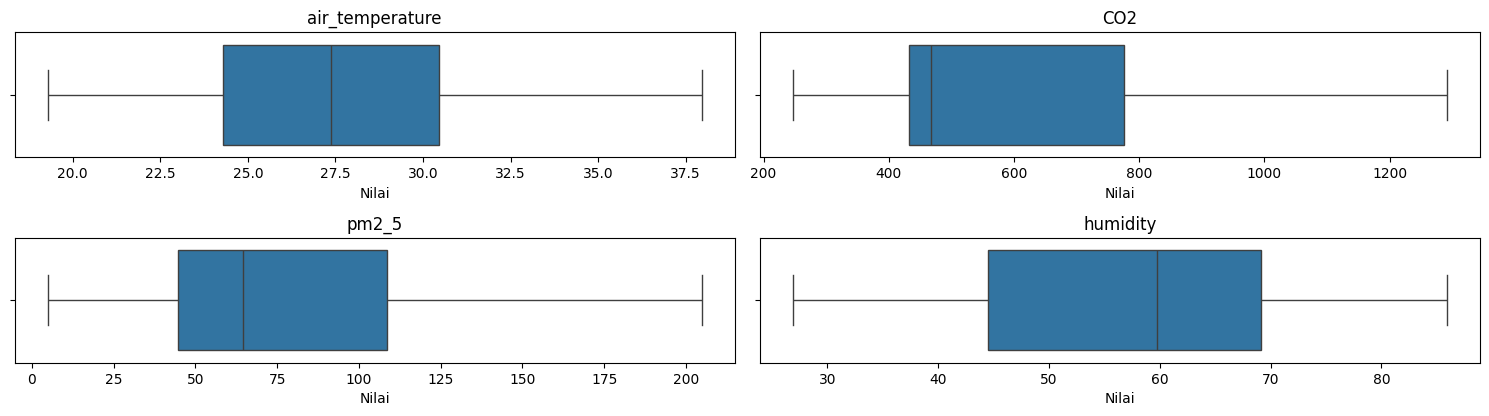

In [ ]:
# Select only numerical columns
numerical_cols = ['air_temperature', 'CO2',	'pm2_5', 'humidity']

# Create boxplots for each numerical column
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(5, 2, i + 1)
    sns.boxplot(x=df[col])
    plt.title(col)
    plt.xlabel('Nilai')

plt.tight_layout()
plt.show()

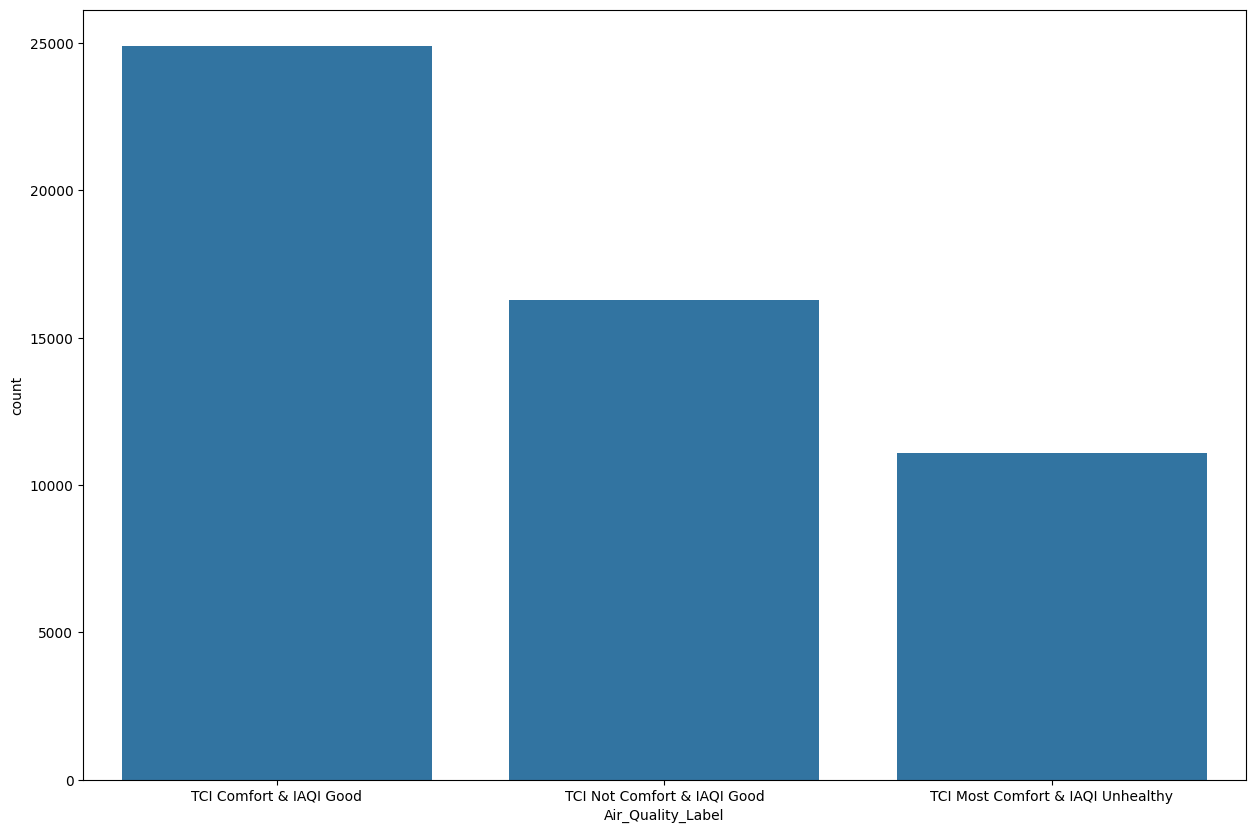

In [ ]:
plt.figure(figsize=(15, 10))
sns.countplot(x='Air_Quality_Label', data=df)
plt.show()

## Checking Correlation (ANOVA)

In [ ]:
from scipy.stats import f_oneway
import pandas as pd
import numpy as np

# Define the features to analyze (using the same features as 'X' was defined)
features_for_anova = ['air_temperature', 'CO2',	'pm2_5', 'humidity']

print("Analisis ANOVA untuk Fitur Numerik vs. Air Quality (menggunakan seluruh dataset):")

# Perform ANOVA for each selected feature
for feature in features_for_anova:
    # Group the numerical feature values by Air Quality
    # Use the original df and the encoded 'Air Quality' column
    groups = [df[feature][df['Air_Quality_Label'] == cls] for cls in np.unique(df['Air_Quality_Label'])]

    # Perform one-way ANOVA
    f_statistic, p_value = f_oneway(*groups)

    print(f"\nFeature: {feature}")
    print(f"  F-statistic: {f_statistic:.4f}")
    print(f"  P-value: {p_value:.4f}")

    if p_value < 0.05: # Using a significance level of 0.05
        print(f"  Terdapat perbedaan rata-rata yang signifikan secara statistik antara kelompok Air Quality untuk fitur {feature}.")
    else:
        print(f"  Tidak terdapat perbedaan rata-rata yang signifikan secara statistik antara kelompok Air Quality untuk fitur {feature}.")

Analisis ANOVA untuk Fitur Numerik vs. Air Quality (menggunakan seluruh dataset):

Feature: air_temperature
  F-statistic: 3624.5776
  P-value: 0.0000
  Terdapat perbedaan rata-rata yang signifikan secara statistik antara kelompok Air Quality untuk fitur air_temperature.

Feature: CO2
  F-statistic: 105820.2345
  P-value: 0.0000
  Terdapat perbedaan rata-rata yang signifikan secara statistik antara kelompok Air Quality untuk fitur CO2.

Feature: pm2_5
  F-statistic: 9600.6193
  P-value: 0.0000
  Terdapat perbedaan rata-rata yang signifikan secara statistik antara kelompok Air Quality untuk fitur pm2_5.

Feature: humidity
  F-statistic: 18833.7081
  P-value: 0.0000
  Terdapat perbedaan rata-rata yang signifikan secara statistik antara kelompok Air Quality untuk fitur humidity.


## Encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
le = LabelEncoder()

# Fit and transform the 'Air Quality' column in the DataFrame
df['Air_Quality_Label'] = le.fit_transform(df['Air_Quality_Label'])

# Display the mapping from original class names to their numerical encoding
print("Original 'Air_Quality_Label' classes and their numerical encoding:")
# Ensure le.classes_ is sorted to match the typical output order if not explicitly sorted
class_mapping = sorted(zip(le.classes_, le.transform(le.classes_)), key=lambda x: x[1])
for class_name, encoded_value in class_mapping:
    print(f"{class_name}: {encoded_value}")

# Update the target variable y with the encoded values
y = df['Air_Quality_Label']

print("\nFirst 5 values of encoded y:")
print(y.head())
print("\nUnique values in encoded y:")
print(y.unique())

Original 'Air_Quality_Label' classes and their numerical encoding:
TCI Comfort & IAQI Good: 0
TCI Most Comfort & IAQI Unhealthy: 1
TCI Not Comfort & IAQI Good: 2

First 5 values of encoded y:
0    0
1    0
2    0
3    0
4    2
Name: Air_Quality_Label, dtype: int64

Unique values in encoded y:
[0 2 1]


## SMOTE

In [ ]:
X = df[['air_temperature', 'CO2', 'pm2_5', 'humidity']]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Class distribution before SMOTE (Training data):")
print(Counter(y_train))

# Initialize and apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("\nClass distribution after SMOTE (Training data):")
print(Counter(y_train_smote))

print("SMOTE has been applied successfully!")

Class distribution before SMOTE (Training data):
Counter({0: 19917, 2: 13033, 1: 8857})

Class distribution after SMOTE (Training data):
Counter({0: 19917, 1: 19917, 2: 19917})
SMOTE has been applied successfully!


## Feature Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit the scaler on the oversampled training data and transform it
X_train_smote_scaled = scaler.fit_transform(X_train_smote);

# Transform the test data using the fitted scaler
X_test_scaled = scaler.transform(X_test);

print("Data telah berhasil di-scaling!")
print(f"Bentuk X_train_smote_scaled: {X_train_smote_scaled.shape}")
print(f"Bentuk X_test_scaled: {X_test_scaled.shape}")
print("Contoh data X_train_smote_scaled (5 baris pertama):\n", X_train_smote_scaled[:5])
print("Contoh data X_test_scaled (5 baris pertama):\n", X_test_scaled[:5])

Data telah berhasil di-scaling!
Bentuk X_train_smote_scaled: (59751, 4)
Bentuk X_test_scaled: (10452, 4)
Contoh data X_train_smote_scaled (5 baris pertama):
 [[ 1.15385699 -0.85482334 -0.5690005  -0.93667254]
 [-1.12464809  1.56031671  0.63781276 -0.07250487]
 [-1.11931201 -0.8132308   1.26068412  0.0394901 ]
 [-0.5190033  -0.8908702  -0.48465334  0.22807519]
 [-0.31356432 -0.88532453  1.56130606  0.16160075]]
Contoh data X_test_scaled (5 baris pertama):
 [[-1.08462751 -0.86591468  0.13389252  0.10740964]
 [ 0.27340421 -0.52208303 -0.0391273   0.55394444]
 [-0.97790596 -0.88809737 -0.12347446 -0.24808409]
 [-1.1113079   1.56031671 -1.34975245  0.07128223]
 [ 2.49588047 -0.88532453 -0.58630249 -1.58552085]]


# Model Training & Evaluation

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Inisialisasi model Random Forest
rf_classifier = RandomForestClassifier(random_state=42)

# Latih model menggunakan data pelatihan yang telah di-oversampling
rf_classifier.fit(X_train_smote_scaled, y_train_smote)

print("Random Forest Classifier telah berhasil dilatih!")

Random Forest Classifier telah berhasil dilatih!


Accuracy: 0.9953
Precision (weighted): 0.9953
Recall (weighted): 0.9953
F1-Score (weighted): 0.9953


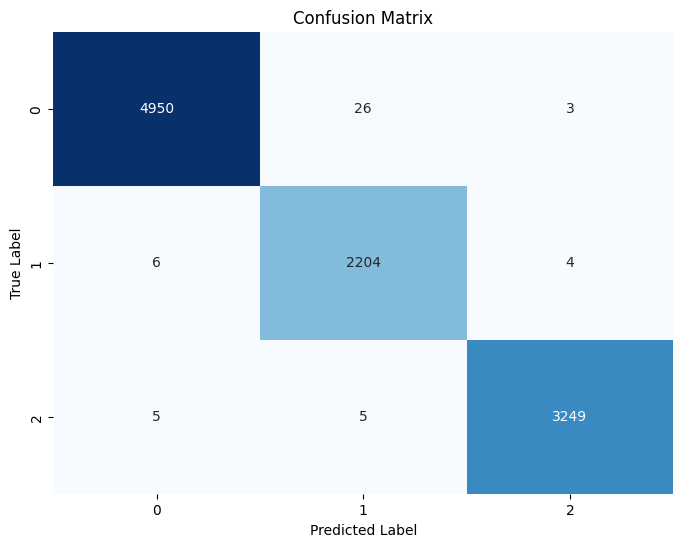

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Prediksi pada data uji
y_pred = rf_classifier.predict(X_test_scaled)

# Hitung metrik evaluasi
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1-Score (weighted): {f1:.4f}")

# Buat Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## XGBoost

In [ ]:
from xgboost import XGBClassifier

# Inisialisasi model XGBoost
xgb_classifier = XGBClassifier(random_state=42)

# Latih model menggunakan data pelatihan yang telah di-oversampling
xgb_classifier.fit(X_train_smote_scaled, y_train_smote)

print("XGBoost Classifier telah berhasil dilatih!")

XGBoost Classifier telah berhasil dilatih!


XGBoost Model Accuracy: 0.9952
XGBoost Model Precision (weighted): 0.9952
XGBoost Model Recall (weighted): 0.9952
XGBoost Model F1-Score (weighted): 0.9952

Classification Report for XGBoost Model:

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4979
           1       0.99      0.99      0.99      2214
           2       1.00      1.00      1.00      3259

    accuracy                           1.00     10452
   macro avg       0.99      1.00      0.99     10452
weighted avg       1.00      1.00      1.00     10452



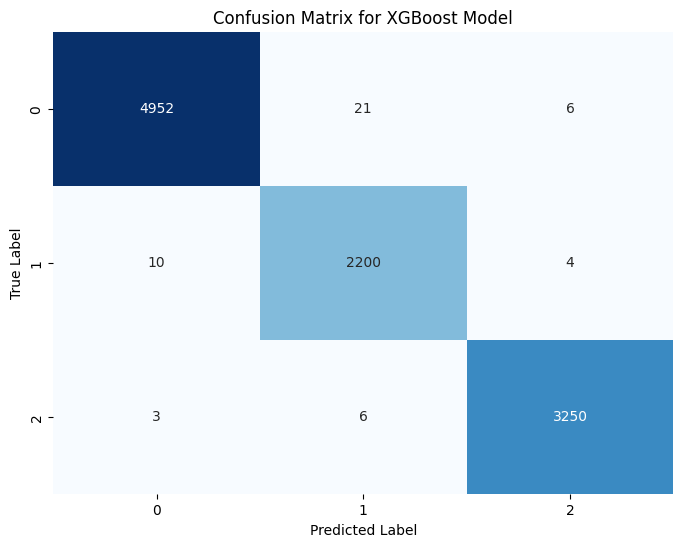

In [ ]:
# Prediksi pada data uji menggunakan XGBoost
y_pred_xgb = xgb_classifier.predict(X_test_scaled)

# Hitung metrik evaluasi untuk XGBoost
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb, average='weighted')
recall_xgb = recall_score(y_test, y_pred_xgb, average='weighted')
f1_xgb = f1_score(y_test, y_pred_xgb, average='weighted')

print(f"XGBoost Model Accuracy: {accuracy_xgb:.4f}")
print(f"XGBoost Model Precision (weighted): {precision_xgb:.4f}")
print(f"XGBoost Model Recall (weighted): {recall_xgb:.4f}")
print(f"XGBoost Model F1-Score (weighted): {f1_xgb:.4f}")

print("\nClassification Report for XGBoost Model:\n")
print(classification_report(y_test, y_pred_xgb))

# Buat Confusion Matrix untuk XGBoost
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for XGBoost Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## LightGBM

In [ ]:
from lightgbm import LGBMClassifier

# Inisialisasi model LightGBM
lgbm_classifier = LGBMClassifier(random_state=42)

# Latih model menggunakan data pelatihan yang telah di-oversampling
lgbm_classifier.fit(X_train_smote_scaled, y_train_smote)

print("LightGBM Classifier telah berhasil dilatih!")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 59751, number of used features: 4
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
LightGBM Classifier telah berhasil dilatih!


LightGBM Model Accuracy: 0.9956
LightGBM Model Precision (weighted): 0.9956
LightGBM Model Recall (weighted): 0.9956
LightGBM Model F1-Score (weighted): 0.9956

Classification Report for LightGBM Model:

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4979
           1       0.99      0.99      0.99      2214
           2       1.00      1.00      1.00      3259

    accuracy                           1.00     10452
   macro avg       0.99      1.00      1.00     10452
weighted avg       1.00      1.00      1.00     10452



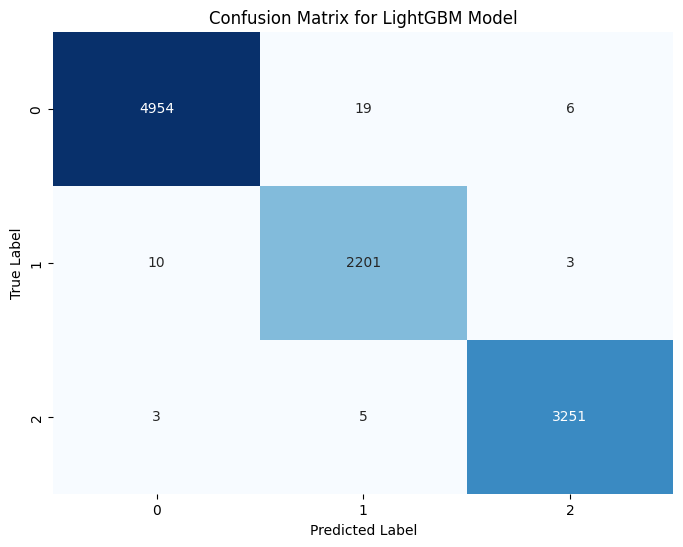

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Prediksi pada data uji menggunakan LightGBM
y_pred_lgbm = lgbm_classifier.predict(X_test_scaled)

# Hitung metrik evaluasi untuk LightGBM
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
precision_lgbm = precision_score(y_test, y_pred_lgbm, average='weighted')
recall_lgbm = recall_score(y_test, y_pred_lgbm, average='weighted')
f1_lgbm = f1_score(y_test, y_pred_lgbm, average='weighted')

print(f"LightGBM Model Accuracy: {accuracy_lgbm:.4f}")
print(f"LightGBM Model Precision (weighted): {precision_lgbm:.4f}")
print(f"LightGBM Model Recall (weighted): {recall_lgbm:.4f}")
print(f"LightGBM Model F1-Score (weighted): {f1_lgbm:.4f}")

print("\nClassification Report for LightGBM Model:\n")
print(classification_report(y_test, y_pred_lgbm))

# Buat Confusion Matrix untuk LightGBM
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lgbm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for LightGBM Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Adaboost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

# Inisialisasi model AdaBoost
adaboost_classifier = AdaBoostClassifier(random_state=42)

# Latih model menggunakan data pelatihan yang telah di-oversampling
adaboost_classifier.fit(X_train_smote_scaled, y_train_smote)

print("AdaBoost Classifier telah berhasil dilatih!")

AdaBoost Classifier telah berhasil dilatih!


AdaBoost Model Accuracy: 0.9619
AdaBoost Model Precision (weighted): 0.9628
AdaBoost Model Recall (weighted): 0.9619
AdaBoost Model F1-Score (weighted): 0.9621

Classification Report for AdaBoost Model:

              precision    recall  f1-score   support

           0       0.98      0.95      0.96      4979
           1       0.91      0.96      0.93      2214
           2       0.98      0.98      0.98      3259

    accuracy                           0.96     10452
   macro avg       0.95      0.96      0.96     10452
weighted avg       0.96      0.96      0.96     10452



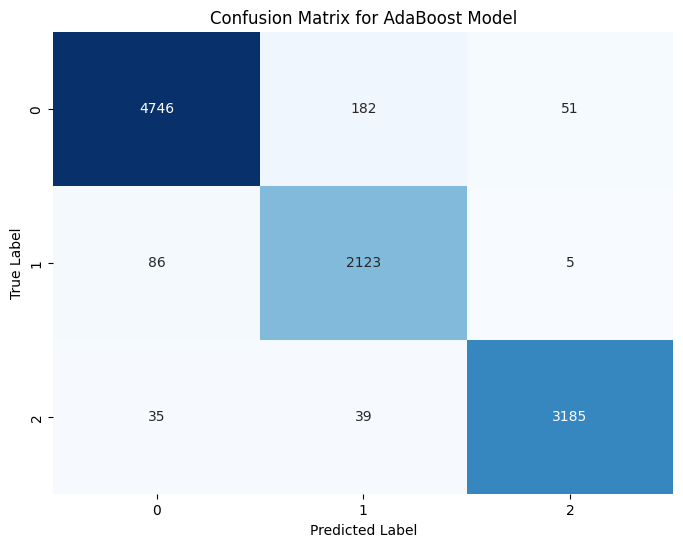

In [ ]:
# Prediksi pada data uji menggunakan AdaBoost
y_pred_adaboost = adaboost_classifier.predict(X_test_scaled)

# Hitung metrik evaluasi untuk AdaBoost
accuracy_adaboost = accuracy_score(y_test, y_pred_adaboost)
precision_adaboost = precision_score(y_test, y_pred_adaboost, average='weighted')
recall_adaboost = recall_score(y_test, y_pred_adaboost, average='weighted')
f1_adaboost = f1_score(y_test, y_pred_adaboost, average='weighted')

print(f"AdaBoost Model Accuracy: {accuracy_adaboost:.4f}")
print(f"AdaBoost Model Precision (weighted): {precision_adaboost:.4f}")
print(f"AdaBoost Model Recall (weighted): {recall_adaboost:.4f}")
print(f"AdaBoost Model F1-Score (weighted): {f1_adaboost:.4f}")

print("\nClassification Report for AdaBoost Model:\n")
print(classification_report(y_test, y_pred_adaboost))

# Buat Confusion Matrix untuk AdaBoost
cm_adaboost = confusion_matrix(y_test, y_pred_adaboost)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_adaboost, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for AdaBoost Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Model Deployment


In [ ]:
import pickle

# Save the best Random Forest model (tuned with Bayesian Optimization)
model_filename = 'adaboost_air_quality_classifier.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(adaboost_classifier, file)

print(f"Model has been saved to {model_filename}")

Model has been saved to adaboost_air_quality_classifier.pkl
